# 2. Grouping Users together!


In [536]:
# Libraries
import pandas as pd
from collections import Counter
from functools import reduce
import numpy as np
from ast import literal_eval  # Import literal_eval to safely evaluate string representation of lists
from sklearn.impute import SimpleImputer
import sklearn
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

# Data processing 
import pandas as pd
import numpy as np



# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as hier
from sklearn.mixture import GaussianMixture

import warnings

# Suppress FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)


Now, we will deal with clustering algorithms that will provide groups of Netflix users that are similar among them.

To solve this task, you must accomplish the following stages:

## 2.1 Getting your data + feature engineering


### 1. Access to the data found in this dataset



In [537]:
# Load data
data = pd.read_csv("vodclickstream_uk_movies_03.csv")
not_clean = data

In [538]:
not_clean.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287


In [539]:
# Cleaning data and adding needed columns

# Remove useless column "Unnamed: 0"
data = data.drop("Unnamed: 0", axis=1)

data["genres"] = data["genres"].apply(lambda x: x.split(", "))

data.drop(data[data["duration"] < 0].index, inplace = True)

data["datetime"] = pd.to_datetime(data["datetime"], errors = 'coerce')
data["release_date"] = pd.to_datetime(data["release_date"], errors = 'coerce')

In [540]:
# Show clean_data df
data.head(10)

,datetime,duration,title,genres,release_date,movie_id,user_id
0,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","[Comedy, Drama, Romance]",2008-07-25,26bd5987e8,1dea19f6fe
1,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"[Fantasy, Horror, Mystery, Thriller]",2016-06-02,f26ed2675e,544dcbc510
2,2017-01-01 15:17:47,10530.0,London Has Fallen,"[Action, Thriller]",2016-03-04,f77e500e7a,7cbcc791bf
3,2017-01-01 16:04:13,49.0,Vendetta,"[Action, Drama]",2015-06-12,c74aec7673,ebf43c36b6
4,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"[Animation, Action, Adventure, Comedy, Family,...",2004-11-19,a80d6fc2aa,a57c992287
5,2017-01-01 19:21:37,0.0,London Has Fallen,"[Action, Thriller]",2016-03-04,f77e500e7a,c5bf4f3f57
6,2017-01-01 19:43:06,4903.0,The Water Diviner,"[Drama, History, War]",2014-12-26,7165c2fc94,8e1be40e32
7,2017-01-01 19:44:38,0.0,Angel of Christmas,"[Comedy, Romance]",2015-11-29,b2f02f2689,892a51dee1
8,2017-01-01 19:46:24,3845.0,Ratter,"[Drama, Horror, Thriller]",2016-02-12,c39aae36c3,cff8ea652a
9,2017-01-01 20:27:04,0.0,The Book of Life,"[Animation, Adventure, Comedy, Family, Fantasy...",2014-10-17,97183b9136,bf53608c70



### 2. Feature Engineering (1)
Sometimes, the features (variables, fields) are not given in a dataset but can be created from it; this is known as feature engineering. For example, the original dataset has several clicks done by the same user, so grouping data by user_id will allow you to create new features for each user:

**a) Favorite genre**

In [541]:
#Favorite genre (i.e., the genre on which the user spent the most time)
def favourite_genere(df):
    df.drop(df[df.duration == 0].index)
    
    # Explode the list of genres into separate rows
    df_expanded = df.explode('genres')

    # Group by 'user_id' and 'genre', summing up the 'time_spent'
    grouped_df = df_expanded.groupby(['user_id', 'genres'])['duration'].sum().reset_index()

    # Find the index of the maximum 'time_spent' for each user
    idx = grouped_df.groupby('user_id')['duration'].idxmax()

    # Create a DataFrame with only the rows corresponding to the maximum 'time_spent' for each user
    favorite_genre_df = grouped_df.loc[idx]

    # Rename columns for clarity
    favorite_genre_df = favorite_genre_df.rename(columns={'genres': 'favorite_genre', 'duration': 'time_spent_on_favorite_genre'})

    # Merge the new DataFrame back to the original DataFrame based on 'user_id'
    df = pd.merge(df, favorite_genre_df[['user_id', 'favorite_genre']], on='user_id', how='left')

    return(df)

In [542]:
data = favourite_genere(data)

**b) Average click duration**

In [543]:
def avg_click_time(df):
    average_click_time_df = df.groupby('user_id')['duration'].mean().reset_index()

    # Rename the columns for clarity
    average_click_time_df = average_click_time_df.rename(columns={'duration': 'average_click_time'})

    # Merge the new DataFrame back to the original DataFrame based on 'user_id'
    df = pd.merge(df, average_click_time_df, on='user_id', how='left')

    return(df)

In [544]:
data = avg_click_time(data)

**c) Time of the day (Morning/Afternoon/Night) when the user spends the most time on the platform (the time spent is tracked through the duration of the clicks)**

In [545]:
def time_day(df):
    df['hour'] = df['datetime'].dt.hour
    preferred_time = df.groupby('user_id')['hour'].agg(lambda x: x.mode().iloc[0])

    mapping = {range(0, 6): 'Night', range(6, 12): 'Morning', range(12, 18): 'Afternoon', range(18, 24): 'Night'}

    # Apply the time_of_day mapping to each user's mode hour
    df['time_of_day'] = df['user_id'].map(preferred_time).apply(lambda x: next((value for key, value in mapping.items() if x in key), None))

    #Drop unwanted columns
    df=df.drop(columns='hour')
    return df

In [546]:
data = time_day(data)

**d) Is the user an old movie lover, or is he into more recent stuff (content released after 2010)?**

In [547]:
def movie_preference(df):
    df['release_date'] = pd.to_datetime(df['release_date'])
    threshold_date = pd.Timestamp('2010-01-01')
    
    # Function to determine movie preference for a user
    def determine_preference(group):
        user_release_dates = group['release_date']
        num_old_movies = sum(date <= threshold_date for date in user_release_dates)
        num_recent_movies = len(user_release_dates) - num_old_movies
        
        # Decide preference based on the majority
        if num_recent_movies >= num_old_movies:
            return 'Recent Content Lover'
        else:
            return 'Old Movie Lover'
    
    # Apply the function for each user
    user_preferences = df.groupby('user_id').apply(determine_preference).reset_index(name='movie_preference')
    
    # Merge the result back to the original dataframe
    df = pd.merge(df, user_preferences, on='user_id', how='left')
    
    return df


In [548]:
data = movie_preference(data)

**e) Average time spent a day by the user (considering only the days he logs in)**

In [549]:
def avg_timespent(df):
    grouped_df = df.groupby(['user_id', 'datetime'])['duration'].sum().reset_index()
    average_duration_per_day = grouped_df.groupby('user_id')['duration'].mean().reset_index()
    average_duration_per_day = average_duration_per_day.rename(columns={'duration': 'average_duration_per_day'})
    df = pd.merge(df, average_duration_per_day, on='user_id', how='left')
    return(df)

In [550]:
data = avg_timespent(data)

Visualize the data for a specific user

In [551]:
data[data["user_id"]=="b15926c011"]

,datetime,duration,title,genres,release_date,movie_id,user_id,favorite_genre,average_click_time,time_of_day,movie_preference,average_duration_per_day
307113,2018-03-21 20:42:47,2400.0,Wild Child,"[Comedy, Drama, Romance]",2008-08-15,c424c83faf,b15926c011,Comedy,3324.693351,Night,Recent Content Lover,3324.693351
307136,2018-03-21 21:22:47,179456.0,Wild Child,"[Comedy, Drama, Romance]",2008-08-15,c424c83faf,b15926c011,Comedy,3324.693351,Night,Recent Content Lover,3324.693351
307990,2018-03-23 23:15:47,1217.0,Wild Child,"[Comedy, Drama, Romance]",2008-08-15,c424c83faf,b15926c011,Comedy,3324.693351,Night,Recent Content Lover,3324.693351
308011,2018-03-23 23:36:04,1401.0,Wild Child,"[Comedy, Drama, Romance]",2008-08-15,c424c83faf,b15926c011,Comedy,3324.693351,Night,Recent Content Lover,3324.693351
308035,2018-03-23 23:59:25,2635.0,Wild Child,"[Comedy, Drama, Romance]",2008-08-15,c424c83faf,b15926c011,Comedy,3324.693351,Night,Recent Content Lover,3324.693351
...,...,...,...,...,...,...,...,...,...,...,...,...
348142,2018-05-14 00:04:10,1444.0,Wild Child,"[Comedy, Drama, Romance]",2008-08-15,c424c83faf,b15926c011,Comedy,3324.693351,Night,Recent Content Lover,3324.693351
348162,2018-05-14 00:28:14,546.0,Wild Child,"[Comedy, Drama, Romance]",2008-08-15,c424c83faf,b15926c011,Comedy,3324.693351,Night,Recent Content Lover,3324.693351
348480,2018-05-15 20:36:56,46.0,Coin Heist,"[Crime, Drama, Romance, Thriller]",2017-01-06,57e2731b38,b15926c011,Comedy,3324.693351,Night,Recent Content Lover,3324.693351
348495,2018-05-15 20:37:42,86.0,Coin Heist,"[Crime, Drama, Romance, Thriller]",2017-01-06,57e2731b38,b15926c011,Comedy,3324.693351,Night,Recent Content Lover,3324.693351


### 3. With the help of ChatGPT and our imagination we thouht of 10 other features we could add to the dataset

ChatGPT helped us select the following:

**1) Ratio between number of movies on weekdays vs. weekends**

In [552]:
def ratio_weekend_weekday(df):
    # Create a new column indicating whether the day is a weekend or weekday
    df['week_day'] = df['datetime'].dt.weekday.map({0: 'weekday', 1: 'weekday', 2: 'weekday', 3: 'weekday', 4: 'weekday', 5: 'weekend', 6: 'weekend'})

    # Count the number of movies seen on weekends and weekdays for each user
    movies_count = df.groupby(['user_id', 'week_day']).size().reset_index(name='count')

    # Pivot the table to have 'weekday' and 'weekend' as columns
    movies_count_pivot = movies_count.pivot(index='user_id', columns='week_day', values='count').reset_index()

    # Fill NaN values with 0
    movies_count_pivot.fillna(0, inplace=True)

    # Calculate the ratio of movies seen on weekends to weekdays 
    movies_count_pivot['ratio_weekend_weekday'] = movies_count_pivot['weekend'] - movies_count_pivot['weekday']
    
    # Merge the ratio back to the original dataframe
    df = pd.merge(df, movies_count_pivot[['user_id', 'ratio_weekend_weekday']], on='user_id', how='left')

    # Drop intermediate columns
    df.drop(columns=['week_day'], inplace=True)

    return df


In [553]:
data = ratio_weekend_weekday(data)

**2-3) Unique Genres and Genres Diversity**


In [554]:
def genere_diversity(df):
    unique_genres = df.explode('genres').groupby('user_id')['genres'].nunique().reset_index()
    
    # Calculate a diversity metric (e.g., Shannon entropy) I asked how to do this to ChatGPT
    unique_genres['genre_diversity'] = -1 * unique_genres['genres'] * \
    unique_genres['genres'].apply(lambda x: x / unique_genres['genres'].sum()).apply(lambda x: 0 if pd.isna(x) else x * (np.log(x) if x != 0 else 0))
    unique_genres = unique_genres.rename(columns={'genres': 'unique_genres'})
    df = pd.merge(df, unique_genres[['user_id', 'unique_genres']], on='user_id', how='left')
    df = pd.merge(df, unique_genres[['user_id', 'genre_diversity']], on='user_id', how='left')
    return(df)

In [555]:
data = genere_diversity(data)

**4) Number of unique shows watched**

In [556]:
def unique_shows(df):
    # Calculate the number of unique shows each user has watched
    unique_movies_count = df.groupby('user_id')['movie_id'].nunique().reset_index(name='unique_shows_count')

    # Merge the result back to the original dataframe
    df = pd.merge(df, unique_movies_count, on='user_id', how='left')

    return df

In [557]:
data = unique_shows(data)

**5) Zapping percentage**


In [558]:
def zapping(df):
    df['time_diff'] = df.groupby('user_id')['datetime'].diff()

    time_threshold = pd.Timedelta('5 minutes')

    # Identify zapping events based on the time threshold
    df['zapping_event'] = (df['time_diff'] <= time_threshold) & (df['time_diff'].notna())

    # Calculate the zapping percentage for each user
    zapping_percentage = df.groupby('user_id')['zapping_event'].mean().reset_index()
    zapping_percentage = zapping_percentage.rename(columns={'zapping_event': 'zapping_percentage'})

    # Merge back to the original DataFrame based on 'user_id'
    df = pd.merge(df, zapping_percentage, on='user_id', how='left')
    columns_to_drop = ['zapping_event', 'time_diff']
    df = df.drop(columns=columns_to_drop)
    return(df)


In [559]:
data = zapping(data)

**6) Average number of shows per month**

In [560]:
#average number of movies per month
def avg_movies_month(df):
    df['month'] = df['datetime'].dt.to_period('M')

    # Group by user_id and month, then count the number of shows
    average_shows_per_month = df.groupby(['user_id', 'month'])['movie_id'].count().reset_index()

    # Calculate the average number of shows per month per user
    average_shows_per_month = average_shows_per_month.groupby('user_id')['movie_id'].mean().reset_index()
    average_shows_per_month = average_shows_per_month.rename(columns={'movie_id': 'average_movies_per_month'})

    df = pd.merge(df, average_shows_per_month, on='user_id', how='left')
    columns_to_drop = ['month']
    df = df.drop(columns=columns_to_drop)
    return(df)

In [561]:
data = avg_movies_month(data)

**7) Average time between watches**


In [562]:
#time since last watch 
def average_time_between_watches(df):
    df = df.sort_values(by=['user_id', 'datetime'])

    # Calculate the time difference between consecutive rows for each user
    df['time_since_last_watch'] = df.groupby('user_id')['datetime'].diff() / pd.Timedelta(days=1)

    # Calculate the average time between watches for each user
    df['average_time_between_watches'] = df.groupby('user_id')['time_since_last_watch'].transform('mean')
    
    # Drop unwanted values
    df = df.drop(columns='time_since_last_watch')
    
    # Fill NaN values with the mode of the non-NaN values
    mode_value = df['average_time_between_watches'].mode().iloc[0]
    df['average_time_between_watches'].fillna(mode_value, inplace=True)


    return df

In [563]:
data = average_time_between_watches(data)

**8) Amount of times the same user has rewatched a serie/movie**

In [564]:
def rewatch(df):
    # Count the number of times each movie/series has been rewatched by the same user
    rewatch_count = df.groupby(['user_id', 'movie_id']).size().reset_index(name='rewatch_count')

    #subtract one so that the first time watching doesn't count
    rewatch_count['rewatch_count'] = rewatch_count['rewatch_count'] - 1
    
    # Calculate the total rewatch count for each user
    total_rewatch_count = rewatch_count.groupby('user_id')['rewatch_count'].sum().reset_index(name='total_rewatch_count')

    # Merge the total rewatch count back to the original dataframe
    df = pd.merge(df, total_rewatch_count, on='user_id', how='left')

    # Create a new column with the total rewatch count, fill NaN with 0
    df['total_rewatch_count_user'] = df['total_rewatch_count'].fillna(0)

    # Drop the intermediate total_rewatch_count column
    df.drop(columns=['total_rewatch_count'], inplace=True)

    return df
    

In [565]:
data = rewatch(data)

**9) Content diversity index**

In [566]:
def calculate_content_diversity_index(df):

    exploded_genres = df.explode('genres')

    # Calculate the number of unique genres each user has watched
    unique_genres_per_user = exploded_genres.groupby('user_id')['genres'].nunique()

    # Calculate the total number of unique genres in the dataset
    total_unique_genres = exploded_genres['genres'].nunique()

    # Normalizing the diversity index
    diversity_index = unique_genres_per_user / total_unique_genres

    # Map the diversity index back to the original DataFrame
    df['content_diversity_index'] = df['user_id'].map(diversity_index)

    return df

In [567]:
data = calculate_content_diversity_index(data)

**10) Favorite Season of the Year**

In [568]:
# Function to assign a season to a date
def assign_season(df):

    df['month'] = df['datetime'].dt.month
    
    conditions = [
    (df['month'] >= 3) & (df['month'] <= 5),
    (df['month'] >= 6) & (df['month'] <= 8),
    (df['month'] >= 9) & (df['month'] <= 11),
    (df['month'] == 12) | (df['month'] <= 2),
    ]

    choices = ['Spring', 'Summer', 'Autumn', 'Winter']


    df['season'] = np.select(conditions, choices, default='Winter')
    
    seasonal_viewing = df.groupby('user_id')['season'].value_counts(normalize=True).unstack(fill_value=0)
    
    favorite_season = seasonal_viewing.idxmax(axis=1)
    
    favorite_season_map = favorite_season.to_dict()
    
    df['favorite_season'] = df['user_id'].map(favorite_season_map)
    
    df = df.drop(columns=['season','month'])   

    return df

In [569]:
data = assign_season(data)

Let's visualize the data now with the new features

In [570]:
data[data["user_id"]=="b15926c011"]

,datetime,duration,title,genres,release_date,movie_id,user_id,favorite_genre,average_click_time,time_of_day,...,ratio_weekend_weekday,unique_genres,genre_diversity,unique_shows_count,zapping_percentage,average_movies_per_month,average_time_between_watches,total_rewatch_count_user,content_diversity_index,favorite_season
449570,2018-03-21 20:42:47,2400.0,Wild Child,"[Comedy, Drama, Romance]",2008-08-15,c424c83faf,b15926c011,Comedy,3324.693351,Night,...,-89.0,18,0.004203,210,0.430122,245.666667,0.074725,527,0.666667,Spring
449571,2018-03-21 21:22:47,179456.0,Wild Child,"[Comedy, Drama, Romance]",2008-08-15,c424c83faf,b15926c011,Comedy,3324.693351,Night,...,-89.0,18,0.004203,210,0.430122,245.666667,0.074725,527,0.666667,Spring
449572,2018-03-23 23:15:47,1217.0,Wild Child,"[Comedy, Drama, Romance]",2008-08-15,c424c83faf,b15926c011,Comedy,3324.693351,Night,...,-89.0,18,0.004203,210,0.430122,245.666667,0.074725,527,0.666667,Spring
449573,2018-03-23 23:36:04,1401.0,Wild Child,"[Comedy, Drama, Romance]",2008-08-15,c424c83faf,b15926c011,Comedy,3324.693351,Night,...,-89.0,18,0.004203,210,0.430122,245.666667,0.074725,527,0.666667,Spring
449574,2018-03-23 23:59:25,2635.0,Wild Child,"[Comedy, Drama, Romance]",2008-08-15,c424c83faf,b15926c011,Comedy,3324.693351,Night,...,-89.0,18,0.004203,210,0.430122,245.666667,0.074725,527,0.666667,Spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450302,2018-05-14 20:21:55,28.0,The Outcasts,[Comedy],2017-04-14,c72e35ec62,b15926c011,Comedy,3324.693351,Night,...,-89.0,18,0.004203,210,0.430122,245.666667,0.074725,527,0.666667,Spring
450303,2018-05-14 21:37:25,475.0,Audrie & Daisy,[Documentary],2016-09-23,e52ac4e2fa,b15926c011,Comedy,3324.693351,Night,...,-89.0,18,0.004203,210,0.430122,245.666667,0.074725,527,0.666667,Spring
450304,2018-05-15 20:36:56,46.0,Coin Heist,"[Crime, Drama, Romance, Thriller]",2017-01-06,57e2731b38,b15926c011,Comedy,3324.693351,Night,...,-89.0,18,0.004203,210,0.430122,245.666667,0.074725,527,0.666667,Spring
450305,2018-05-15 20:37:42,86.0,Coin Heist,"[Crime, Drama, Romance, Thriller]",2017-01-06,57e2731b38,b15926c011,Comedy,3324.693351,Night,...,-89.0,18,0.004203,210,0.430122,245.666667,0.074725,527,0.666667,Spring


In [571]:
print(data.dtypes)

datetime                        datetime64[ns]
duration                               float64
title                                   object
genres                                  object
release_date                    datetime64[ns]
movie_id                                object
user_id                                 object
favorite_genre                          object
average_click_time                     float64
time_of_day                             object
movie_preference                        object
average_duration_per_day               float64
ratio_weekend_weekday                  float64
unique_genres                            int64
genre_diversity                        float64
unique_shows_count                       int64
zapping_percentage                     float64
average_movies_per_month               float64
average_time_between_watches           float64
total_rewatch_count_user                 int64
content_diversity_index                float64
favorite_seas

In [572]:
data.describe()

,datetime,duration,release_date,average_click_time,average_duration_per_day,ratio_weekend_weekday,unique_genres,genre_diversity,unique_shows_count,zapping_percentage,average_movies_per_month,average_time_between_watches,total_rewatch_count_user,content_diversity_index
count,650002,6.500020e+05,620565,6.500020e+05,6.500020e+05,650002.000000,650002.000000,650002.000000,650002.000000,650002.000000,650002.000000,650002.000000,650002.000000,650002.000000
mean,2018-04-22 07:02:01.963577856,3.459540e+04,2012-03-29 14:32:15.373087488,3.459540e+04,3.666408e+04,-4.339608,8.772651,0.001313,9.468111,0.160198,8.331862,2.286212,5.244084,0.324913
min,2017-01-01 00:02:21,0.000000e+00,1920-10-01 00:00:00,0.000000e+00,0.000000e+00,-111.000000,1.000000,0.000016,1.000000,0.000000,1.000000,0.000000,0.000000,0.037037
25%,2017-09-14 20:29:01,0.000000e+00,2009-11-25 00:00:00,2.152250e+03,2.360750e+03,-6.000000,5.000000,0.000363,2.000000,0.000000,3.000000,0.415827,0.000000,0.185185
50%,2018-04-12 18:04:07,4.300000e+01,2015-05-01 00:00:00,1.092471e+04,1.179480e+04,-2.000000,8.000000,0.000893,5.000000,0.130435,5.000000,1.241543,2.000000,0.296296
75%,2018-12-15 12:58:21.249999872,7.059000e+03,2017-04-28 00:00:00,3.065360e+04,3.260796e+04,1.000000,12.000000,0.001939,11.000000,0.250000,10.000000,2.704917,5.000000,0.444444
max,2019-06-30 23:59:20,1.823725e+07,2020-10-30 00:00:00,1.147194e+07,1.147194e+07,86.000000,23.000000,0.006706,210.000000,0.923077,245.666667,244.805058,527.000000,0.851852
std,NaN,1.599291e+05,NaN,1.039437e+05,1.082688e+05,10.159049,4.544741,0.001172,14.154136,0.168973,13.669171,3.800391,22.192433,0.168324


## 2.2

### 1. To normalise or not to normalise? 

Let's normalise the **numerical features** and select the best ones for the dimensionality reduction (and clustering)

In [573]:
numerical_features = data.select_dtypes(['float64','int64']).columns 
numerical_features

Index(['duration', 'average_click_time', 'average_duration_per_day',
       'ratio_weekend_weekday', 'unique_genres', 'genre_diversity',
       'unique_shows_count', 'zapping_percentage', 'average_movies_per_month',
       'average_time_between_watches', 'total_rewatch_count_user',
       'content_diversity_index'],
      dtype='object')

In [574]:
data_norm = data.copy()

In [575]:
#MinMaxScalre takes care of NaN values
scaler = MinMaxScaler()

# Fit and transform the selected continuous features
data_norm[numerical_features] = scaler.fit_transform(data_norm[numerical_features])

<Axes: >

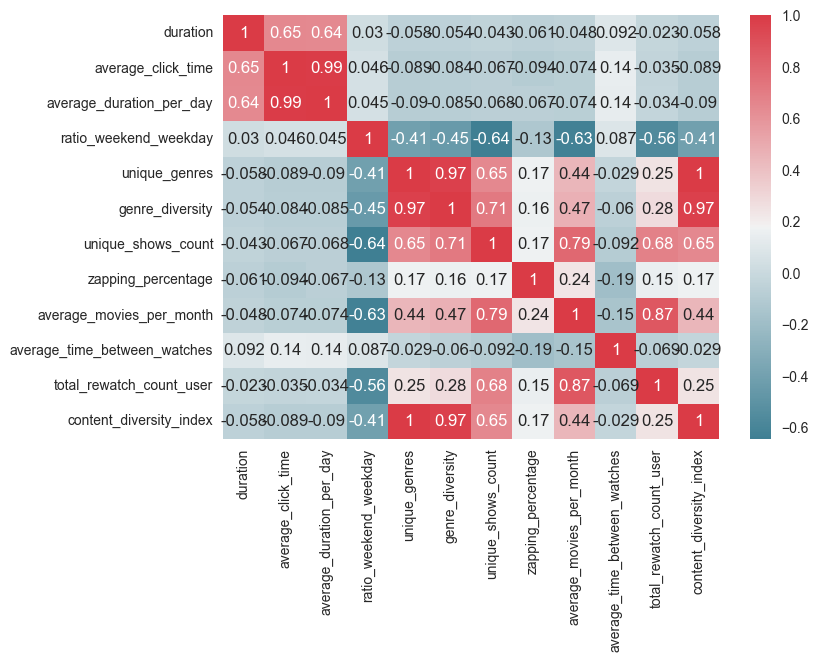

In [576]:
import seaborn as sns
corr = data_norm[numerical_features].corr()
#we are building a heatmap for getting the pairwise correlation between the features:
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            annot=True)

Looking at this correlation matrix we can see that some variables are too correlated with each other so we need to drop redundant variables and keep the useful and independent.

The last 8 features (except 'average_time_between_watches') are highly correlated so we chose to only keep 3.
Same thing with the first 3, we only kept 'average_duration_per_day'

Keep: 'average_duration_per_day','ratio_weekend_weekday', 'zapping_percentage', 'average_movies_per_month','average_time_between_watches', 'content_diversity_index'

Let's analyze now the **categorical features** and transform them in numerical values using *LabelEncoder* 

In [577]:
categorical_features =data_norm.select_dtypes(['object','bool']).columns
categorical_features

Index(['title', 'genres', 'movie_id', 'user_id', 'favorite_genre',
       'time_of_day', 'movie_preference', 'favorite_season'],
      dtype='object')

of course the first 4 columns aren't useful and don't need to me encoded

In [578]:
categorical_features = ['favorite_genre',
        'time_of_day', 'movie_preference', 'favorite_season']

In [579]:
label_encoder = LabelEncoder()

data_norm[categorical_features] = data_norm[categorical_features].apply(label_encoder.fit_transform)

<Axes: >

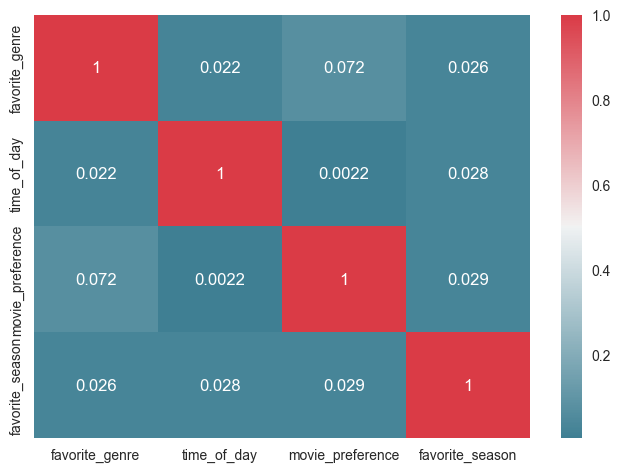

In [580]:
# Calculate the correlation matrix
corr = data_norm[categorical_features].corr()

# Plot the heatmap with the custom color palette
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            annot=True)


They are all independent so we chose to keep them all.

These are the selected features for the dimensionality reduction:

In [581]:

features = ['user_id','average_duration_per_day','ratio_weekend_weekday', 
            'zapping_percentage', 'average_movies_per_month','average_time_between_watches', 
            'content_diversity_index','favorite_genre',
        'time_of_day', 'movie_preference', 'favorite_season']

data_norm_reduced = data_norm[features]

Now of course we need to drop all the duplicates and keep one row for each user

In [582]:
data_norm_reduced = data_norm_reduced.drop_duplicates(subset='user_id', keep='first')
data_norm_reduced

,user_id,average_duration_per_day,ratio_weekend_weekday,zapping_percentage,average_movies_per_month,average_time_between_watches,content_diversity_index,favorite_genre,time_of_day,movie_preference,favorite_season
0,00004e2862,0.000000,0.558376,0.000000,0.000000,0.000000,0.090909,5,2,0,3
1,000052a0a0,0.000235,0.553299,0.451389,0.044959,0.006037,0.590909,0,2,1,2
25,000090e7c8,0.000000,0.558376,0.000000,0.000000,0.000000,0.090909,14,2,1,1
26,000118a755,0.000000,0.548223,0.000000,0.008174,0.000314,0.045455,11,2,1,2
29,000296842d,0.001685,0.548223,0.464286,0.024523,0.000625,0.136364,7,2,1,3
...,...,...,...,...,...,...,...,...,...,...,...
649986,fffd9bf758,0.000741,0.558376,0.000000,0.000000,0.000000,0.090909,5,2,1,2
649987,fffe7b777b,0.000156,0.568528,0.000000,0.000000,0.000000,0.090909,7,0,1,2
649988,fffeac83be,0.003540,0.517766,0.098485,0.018392,0.017173,0.363636,7,2,1,2
649999,ffff2c5f9e,0.000000,0.573604,0.000000,0.004087,0.000050,0.181818,0,0,1,2


### 2. Dimensionality reduction

Principal Component Analysis (PCA) is a statistical technique used for dimensionality reduction and feature extraction in data analysis. It is particularly useful in reducing the number of variables in a dataset while retaining as much of the original information as possible. Here are some advantages or pros of using PCA:

1. **Data Visualization:** PCA is often used for data visualization purposes. It allows you to project high-dimensional data onto a lower-dimensional space (usually 2 or 3 dimensions) while preserving the most important information. This facilitates the identification of patterns, clusters, or trends in the data.

2. **Collinearity Handling:** PCA can be useful when dealing with multicollinearity, a situation where independent variables in a dataset are highly correlated. The principal components are orthogonal, meaning they are uncorrelated, which can help mitigate the collinearity issue.


In [583]:
data_pca=data_norm_reduced.loc[:,data_norm_reduced.columns != 'user_id']

It's important for PCA to standardize the data

In [584]:
scaler = StandardScaler()
data_pca = scaler.fit_transform(data_pca)

In [585]:
# Applying PCA to the features
pca = PCA() 
pca_components = pca.fit_transform(data_pca)

Now we want to see how many components are necessary using the *explained_variance_ratio_* function

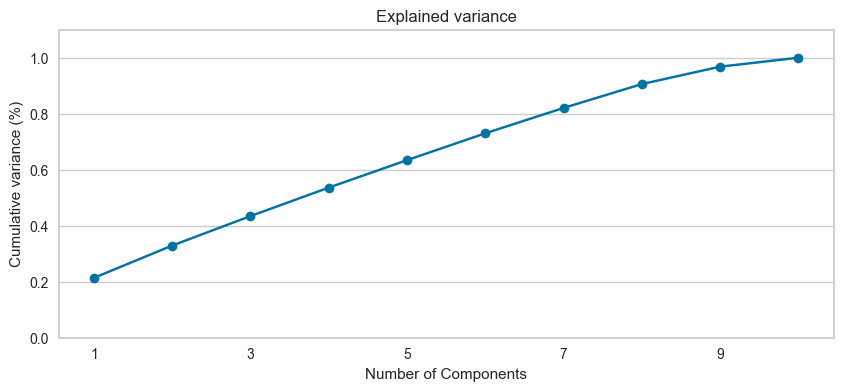

In [586]:
# Explained variance 
pca = PCA().fit(data_pca)
fig, ax = plt.subplots(figsize=(10,4))
xi = np.arange(1, 1+data_pca.shape[1], step=1)
yi = np.cumsum(pca.explained_variance_ratio_)
plt.plot(xi, yi, marker='o')

# Aesthetics
plt.ylim(0.0,1.1)
plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 1+data_pca.shape[1], step=2))
plt.ylabel('Cumulative variance (%)')
plt.title('Explained variance')
ax.grid(axis='x')

A good number of features could be when the cumulative variance is at 80%

In [587]:
# Calculating the cumulative explained variance
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Determining the number of components 
n_components = np.argmax(cumulative_variance_ratio >= 0.80) + 1
n_components

7

Applying PCA with the chosen number of components (7, in this case)

In [588]:
pca = PCA(n_components=n_components)
data_reduced = pca.fit_transform(data_pca)

As we said earlier PCA is useful to visualize the data, so now we plot the first two principal components in a 2D graph and the first three principal components in the 3D model below.

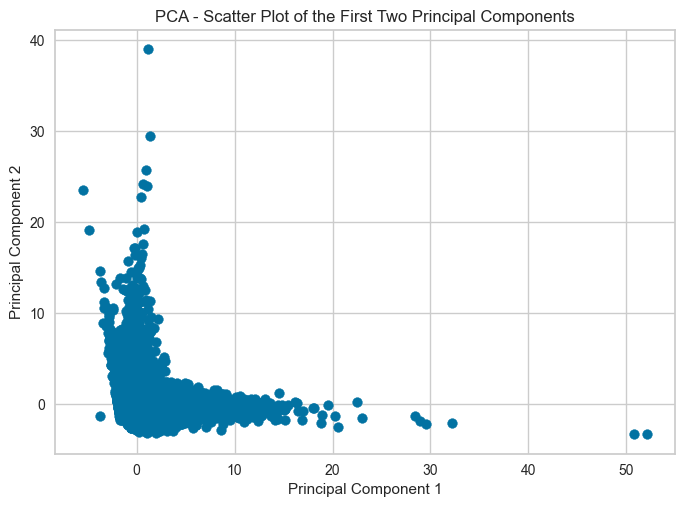

In [589]:
plt.scatter(data_reduced[:, 0], data_reduced[:, 1])
plt.title('PCA - Scatter Plot of the First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

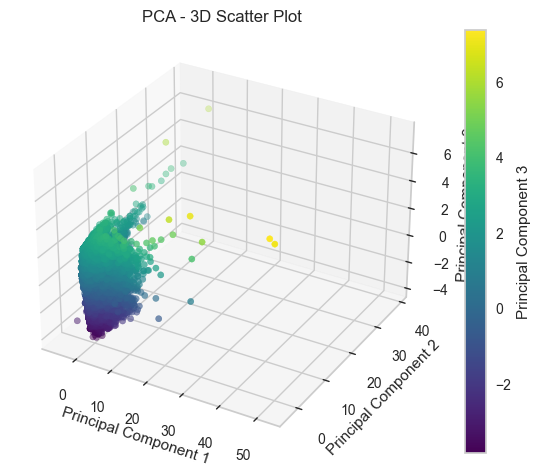

In [590]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming data_reduced is a 2D array from PCA
# and third_dimension is a 1D array with values for the third dimension
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(data_reduced[:, 0], data_reduced[:, 1],data_reduced[:, 2] , c=data_reduced[:, 2], cmap='viridis')

ax.set_title('PCA - 3D Scatter Plot')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Adding a colorbar
cbar = fig.colorbar(scatter, ax=ax, label='Principal Component 3')

plt.show()


In [591]:
#converting the PCA reduced data to a pandas dataframe.
data_final=pd.DataFrame(data_reduced)

#We want the User ID to still be the primary key for our projected data 

data_final.index = data_norm_reduced['user_id']
data_final

,0,1,2,3,4,5,6
user_id,,,,,,,
00004e2862,-1.048322,-1.506168,0.586066,1.241243,0.544535,0.419952,-1.714800
000052a0a0,3.470310,-0.613362,0.541658,0.211986,1.006471,-0.542008,1.457044
000090e7c8,-0.584572,-0.110177,-1.440874,0.362781,-1.685428,-0.590317,-0.806439
000118a755,-0.259728,-0.420331,-1.390965,0.642282,-0.693939,-0.399078,-0.918880
000296842d,1.452601,-1.367514,-1.325479,0.747585,0.430428,0.123207,0.540403
...,...,...,...,...,...,...,...
fffd9bf758,-0.831037,-0.428220,-0.674920,0.516855,0.071369,-0.642214,-0.180091
fffe7b777b,-1.086489,0.022871,-1.081861,-1.200653,0.188887,0.787000,-0.391845
fffeac83be,2.026405,0.469810,-0.213639,0.805002,0.140555,-0.486430,-0.716628


## 2.3


### 1

**Outline of the code**

1. Initialize random centroids
2. Get labels for each data point (Map)
3. Create new centroids (Reduce)
4. Plot the centroids
5. Repeat 3-5 until the centroids stop changing


In [592]:

def assign_centroid(centroids,p):
    distances = [np.linalg.norm(p - centroid) for centroid in centroids]
    closest_centroid = np.argmin(distances)
    return closest_centroid

def map_(data, centroids):
    cluster_assignments = []
    for point in data:
        cluster_assignments.append((assign_centroid(centroids, point), point))
    return cluster_assignments

def reduce_(cluster_assignments, k):
    cluster_assignments = np.array(cluster_assignments, dtype=object)
    new_centroids = [np.mean(cluster_assignments[cluster_assignments[:, 0] == i][:, 1], axis=0) for i in range(k)]
    return new_centroids

def plot_clusters(data,centroids,cluster_assignments, k, i):
    # In order to visualize the clustering process we use PCA once again to make a 2-dimentional plot
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)
    centroids_2d = pca.transform(centroids)
    cluster_ids, clustered_data = zip(*cluster_assignments)
    
    # Plot the clustered data
    plt.scatter(data_2d[:, 0], data_2d[:, 1], c=cluster_ids, cmap='viridis', alpha=0.7)
    plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], s=100, c='red')
    plt.title(f'Iteration (i={i})')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()
    
# K-means algorithm
def Kmeans_from_scratch_with_plot_mapreduce(data, k):
    
    # Step 1: Initialize centroids randomly
    centroids = data[np.random.choice(len(data), k, replace=False)]
    
    #we chose 100 as the max number of iterations as a stopping point
    for i in range(100):
        # Step 2: Get labels for each data point (Map)
        cluster_assignments = map_(data, centroids)
        
        # Step 3: Create new centroids (Reduce)
        new_centroids = reduce_(cluster_assignments, k)
        
        # Step 5: Repeat 3-5 until the centroids stop changing
        if np.all(np.array(new_centroids) == np.array(centroids)):
            # Step 4: Plot the centroids
            plot_clusters(data,centroids,cluster_assignments, k, i)
            break

        # Update centroids for the next iteration
        centroids = new_centroids

    return centroids

### 2


Find an optimal number of clusters.

#### Method 1: Elbow

The elbow method is the most widely used method for choosing the number of clusters. It runs clustering models for a range of cluster numbers and plots the within cluster sum of squares. The elbow on the plot shows the point where the diminishing returns for additional clusters happen.

In [593]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score

C:\Users\Gabriele\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\yellowbrick\utils\kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Gabriele\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\yellowbrick\cluster\elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


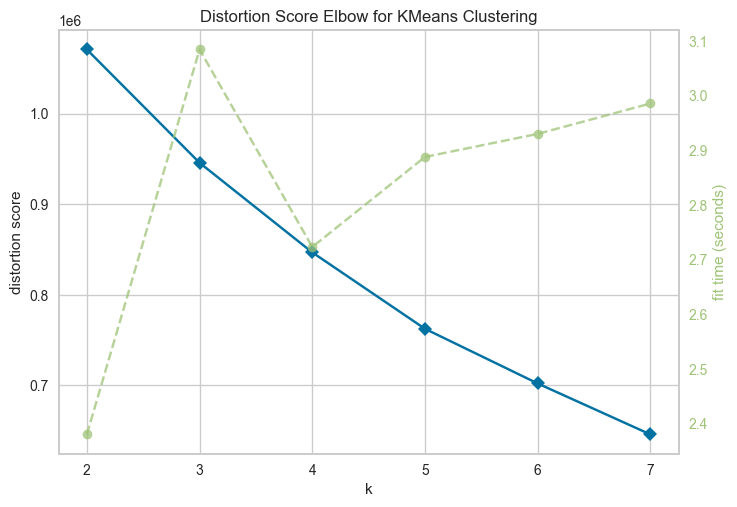

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [594]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,8))

visualizer.fit(data_reduced)
visualizer.show()

##### Method 2: Silhouette method

In [595]:
#We took a sample of 10,000 items from our dataset
data_sample = data_final.sample(10000)

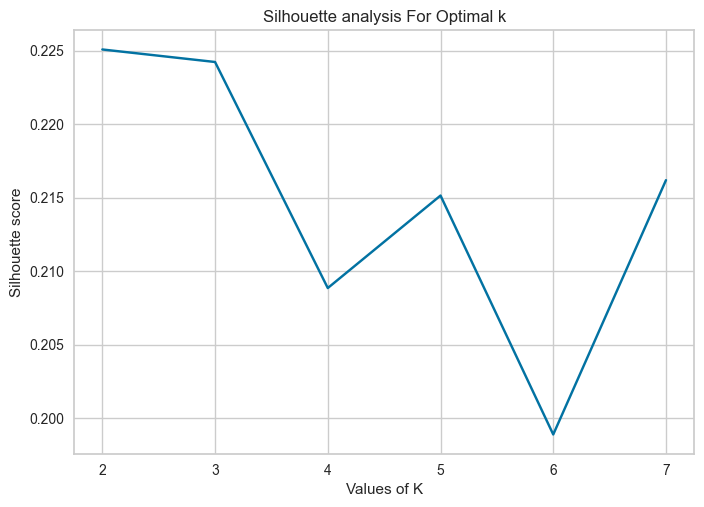

In [596]:
clusters = [2, 3, 4, 5, 6, 7]
silhouette_avg = []

for cluster in clusters:
    kmeans=KMeans(n_clusters=cluster, random_state=42).fit(data_sample)
    cluster_labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(data_sample, cluster_labels))
    
plt.plot(clusters,silhouette_avg,'bx-')    
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

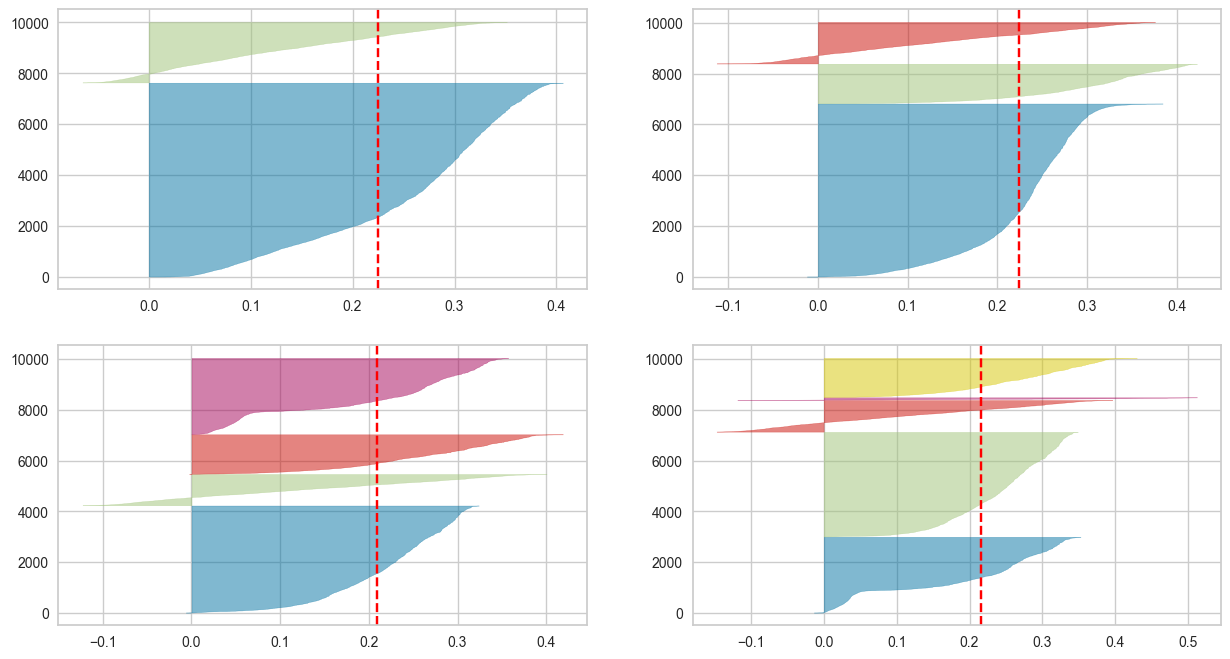

In [597]:
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    km = KMeans(n_clusters=i, random_state=42)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(data_sample)
    cluster_labels = km.fit_predict(data_sample)
    silhouette_avg = silhouette_score(data_sample, cluster_labels)

#### Method 3: Hierarchical Graph

The y axis is the euclidean distance, so the longer the vertical line is, the larger distance between the clusters.

From the graph, we can see that the two clusters connected by the blue line have the largest distance, and the two sub-clusters in red have a relatively large distance too. Therefore, the hierarchical graph suggests 2 or 3 clusters as well.

Text(0, 0.5, 'Euclidean Distance')

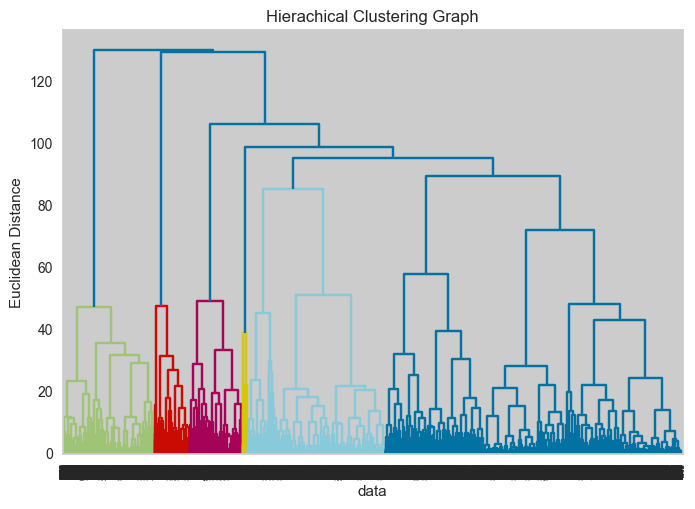

In [598]:
# Change figure size
#plt.figure(figsize=(16,12))
plt.figure()

# Fit the heirachical graph
heirachical_graph=hier.dendrogram(hier.linkage(data_sample, method='ward')) #method='ward' uses the Ward variance minimization algorithm

# Add titles and labels
plt.title('Hierachical Clustering Graph')
plt.xlabel('data')
plt.ylabel('Euclidean Distance')

- Unfortunately Method 1 (Elbow) didn't give us a visible elbow
- Method 2 (Silhouette) seems to suggest k=2 or 3 but there was no clear winner
- Method 3 (Hierarchical) has 5 blue lines suggesting k=6

Since all three methods didn't yield a significant result, we based our choice on the plot of the first principal components. The plot in question showed that there are not well defined clusters, so we implemented the clustering algorithms with the lowest number of clusters that can give meaningful results (**3**, in this case) so that we can avoid excessive partitioning of the data or, on the other side, too simplistic answers.

### 3. Run the algorithm on the data obtained from the dimensionality reduction.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


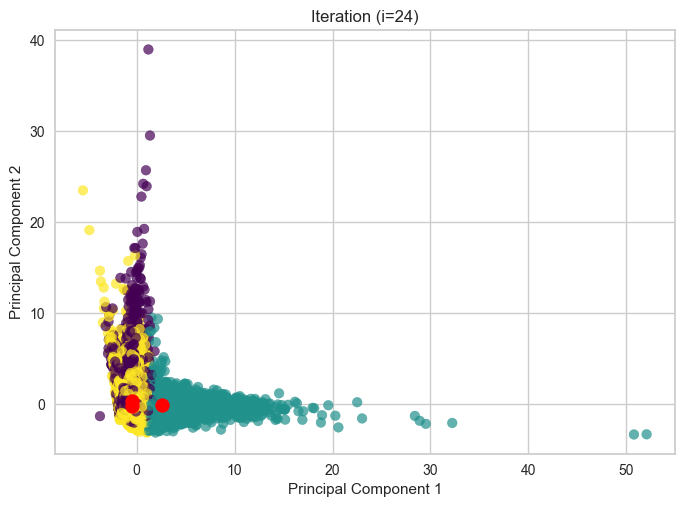

In [600]:
optimal_k=3
final_centroids = Kmeans_from_scratch_with_plot_mapreduce(data_reduced, optimal_k)

This is a plot is losing a lot of dimensions, so even though two final centroids seem overlapping they might be actually distant 

### 4. Implement K-means++ from scratch and explain the differences with the results you got earlier.

In [601]:
def kmeans_plusplus_init(data, k):
    # Choose the first centroid randomly from the data points
    centroids = [data[np.random.choice(data.shape[0])]]
    #centroids = data[np.random.choice(len(data), 1, replace=False)]
    # Choose the remaining centroids using K-means++ method
    for _ in range(1, k):
        # Calculate distances from each data point to the nearest existing centroid
        distances = np.array([min(np.linalg.norm(point - np.array(centroid)) for centroid in centroids) for point in data])

        # Calculate probabilities for each data point based on squared distances
        probabilities = distances**2 / np.sum(distances**2)

        # Choose the next centroid randomly from the data points based on probabilities
        new_centroid = data[np.random.choice(data.shape[0], p=probabilities)]
        centroids.append(new_centroid)

    return np.array(centroids)

This implementation randomly selects the first centroid and then chooses the subsequent centroids with a probability proportional to the squared distance from the nearest existing centroid. This ensures that the initial centroids are well spread out in the data space.

K-means++ is typically used as the initialization step to provide better starting points for convergence. in fact other than the initial centroids the code is the same as before

In [602]:
# K-means++ algorithm
def Kmeans_pp_from_scratch_with_plot_mapreduce(data, k):
    # Step 1: Initialize centroids with the new method (++)
    centroids = kmeans_plusplus_init(data, k)

    for i in range(100):
        # Step 2: Get labels for each data point (Map)
        cluster_assignments = map_(data, centroids)
        
        # Step 3: Create new centroids (Reduce)
        new_centroids = reduce_(cluster_assignments, k)
                
        # Step 5: Repeat 3-5 until the centroids stop changing
        if np.all(np.array(new_centroids) == np.array(centroids)):
            # Step 4: Plot the centroids
            plot_clusters(data,centroids,cluster_assignments, k, i)
            break

        # Update centroids for the next iteration
        centroids = new_centroids

    return centroids

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


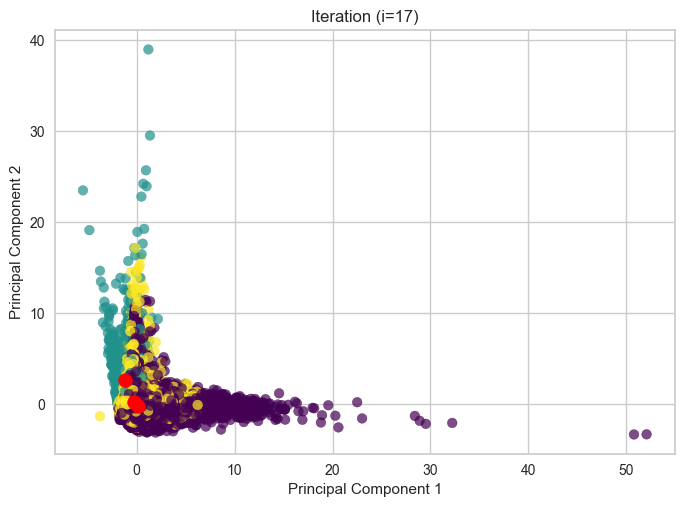

In [603]:
final_centroids = Kmeans_pp_from_scratch_with_plot_mapreduce(data_reduced, optimal_k)

 This method is supposed to reduce the number of iteration (faster convergence). This means that, over many runs, this last algorithm will always give a consistently low number of iterations, and the former will be more unstable depending on the first random centroids. The clusters don't seem to be more defined than before.

### 5. Ask ChatGPT to recommend other clustering algorithms and choose one. Explain your choice, then ask ChatGPT to implement it or use already implemented versions (e.g., the one provided in the scikit-learn library) and run it on your data. Explain the differences (if there are any) in the results. Which one is the best, in your opinion, and why?

Gaussian Mixture Model (GMM) is a probabilistic model that represents a mixture of multiple Gaussian distributions. It is often used for clustering and density estimation. These are some advantages or pros of using Gaussian Mixture Models:

1. **Flexibility in Modeling Complex Distributions:** GMMs are capable of modeling complex probability distributions by combining multiple Gaussian components. This flexibility allows GMMs to represent a wide range of data patterns and structures.

2. **Soft Assignment of Data Points:** Unlike hard clustering algorithms that assign each data point to a single cluster, GMMs provide a soft assignment by assigning probabilities to each data point belonging to each cluster. This soft assignment can be more realistic in situations where data points may belong to multiple clusters simultaneously.

3. **No Assumption of Equal Cluster Sizes or Variances:** Unlike K-means, which assumes equal cluster sizes and variances, GMMs do not impose such constraints. This makes GMMs more suitable for situations where the clusters have varying sizes and shapes.

4. **Density Estimation:** GMMs can be used for density estimation, allowing for the estimation of the underlying probability distribution of the data. This is useful in applications such as anomaly detection.

The last two points highlight the specific reasons for choosing the Gaussian Mixture Model (GMM) in our analysis. Based on the results from the previous clustering, it appears that we are dealing with the subdivision of one large cluster. By opting for the GMM method, we can take into account the density of the points, considering not only the distance from a centroid but also the probability distribution. This is crucial, as GMMs allow for clusters of different sizes and shapes, accommodating the inherent variability in the data rather than assuming equal cluster sizes and variances, as done in traditional methods like K-means. The ability of GMMs to perform density estimation further enhances our capability to identify and handle anomalies effectively in the dataset.

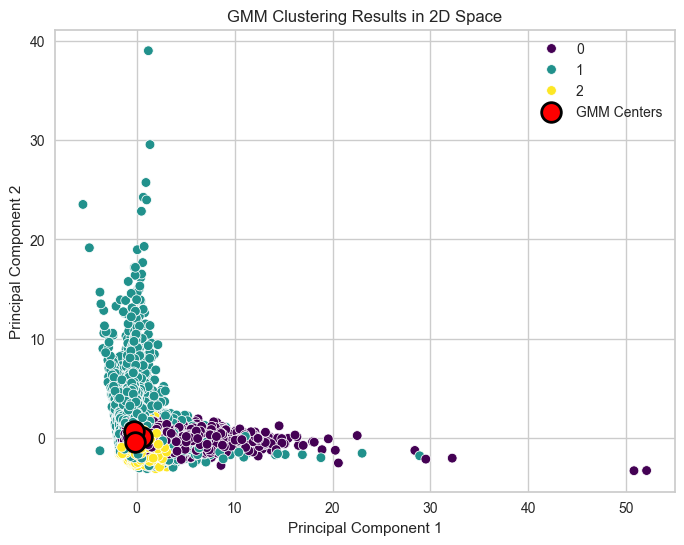

In [604]:
from sklearn.mixture import GaussianMixture

# Create a Gaussian Mixture Model
gmm = GaussianMixture(n_components=optimal_k)

# Fit the GMM to the reduced data
gmm.fit(data_reduced)

# Predict the cluster labels for each data point
cluster_labels = gmm.predict(data_reduced)

# You can also obtain the probabilities of each sample belonging to each cluster
# This can be useful for assessing the uncertainty of the clustering
probs = gmm.predict_proba(data_reduced)

# Now, cluster_labels contains the cluster assignments for each data point
# probs contains the probability scores for each data point in each cluster
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data_reduced[:, 0], y=data_reduced[:, 1], hue=cluster_labels, palette='viridis', legend='full')

# Plot the GMM cluster centers
means = gmm.means_
plt.scatter(means[:, 0], means[:, 1], marker='o', s=200, c='red', edgecolors='black', linewidths=2, label='GMM Centers')

plt.title('GMM Clustering Results in 2D Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

It is evident that the data exhibits a more complex structure than a simple partition into equally sized and shaped clusters. In particular, the analysis reveals the presence of a more dense cluster (referred to as Cluster 2) located in the middle of the plotted points. This observation aligns with the advantages of using GMMs, as highlighted before.

## 2.4 Analysing your results! 

You are often encouraged to explain the main characteristics that your clusters have. The latter is called the Characterizing Clusters step. Thus, follow the next steps to do it:

Let's use our Kmeans++ algorithm

In [628]:
cluster_assignments = map_(data_reduced, final_centroids)
cluster_assignments = np.array(cluster_assignments, dtype=object)
cluster_assignments[:, 0]

array([0, 0, 0, ..., 0, 2, 0], dtype=object)

In [606]:
#Create an empty column to add to the dataframe
data_norm_reduced['Cluster'] = data_norm_reduced.apply(lambda _: '', axis=1)
data_norm_reduced.head()

,user_id,average_duration_per_day,ratio_weekend_weekday,zapping_percentage,average_movies_per_month,average_time_between_watches,content_diversity_index,favorite_genre,time_of_day,movie_preference,favorite_season,Cluster
0,00004e2862,0.000000,0.558376,0.000000,0.000000,0.000000,0.090909,5,2,0,3,
1,000052a0a0,0.000235,0.553299,0.451389,0.044959,0.006037,0.590909,0,2,1,2,
25,000090e7c8,0.000000,0.558376,0.000000,0.000000,0.000000,0.090909,14,2,1,1,
26,000118a755,0.000000,0.548223,0.000000,0.008174,0.000314,0.045455,11,2,1,2,
29,000296842d,0.001685,0.548223,0.464286,0.024523,0.000625,0.136364,7,2,1,3,


In [629]:
#Fill the column with the corresponding cluster for each customer
data_norm_reduced['Cluster'] = cluster_assignments[:, 0]+1

In [630]:
data_norm_reduced['Cluster'].head()

0     1
1     1
25    1
26    1
29    1
Name: Cluster, dtype: object

In [631]:
#Counting how many customers are in each cluster
c1 = 0
c2 = 0
c3 = 0
for i in data_norm_reduced['Cluster']:
  if i == 1:
    c1 += 1
  if i == 2:
    c2 += 1
  if i == 3:
    c3 += 1
print( c1, c2, c3)
print(c1+c2+c3)

95917 2411 56060
154388


In [632]:
data_norm_reduced.columns

Index(['user_id', 'average_duration_per_day', 'ratio_weekend_weekday',
       'zapping_percentage', 'average_movies_per_month',
       'average_time_between_watches', 'content_diversity_index',
       'favorite_genre', 'time_of_day', 'movie_preference', 'favorite_season',
       'Cluster'],
      dtype='object')

#### 1. Select 2-3 variables you think are relevant to identify the cluster of the customer. 

In [633]:
#Select variables we think are important to identify a cluster
data1 = pd.DataFrame(data_norm_reduced, columns=['ratio_weekend_weekday', 'average_duration_per_day', 'zapping_percentage', 'Cluster'])
data1.head()

,ratio_weekend_weekday,average_duration_per_day,zapping_percentage,Cluster
0,0.558376,0.000000,0.000000,1
1,0.553299,0.000235,0.451389,1
25,0.558376,0.000000,0.000000,1
26,0.548223,0.000000,0.000000,1
29,0.548223,0.001685,0.464286,1


#### 2. Most of your selected variables will be numerical (continuous or discrete), then categorise them into four categories.

In [634]:
#Add a column with the respective category for each numerical variable 
data1['Categories_ratio_weekend_weekday'] = pd.cut(data1['ratio_weekend_weekday'], [0, .25, .5, .75, 1.], labels=[1,2,3,4], include_lowest=True) 
data1['Categories_average_duration_per_day'] = pd.cut(data1['average_duration_per_day'], [0, .25, .5, .75, 1.], labels=[1,2,3,4],include_lowest=True)
data1['Categories_zapping_percentage'] = pd.cut(data1['zapping_percentage'], [0, .25, .5, .75, 1.], labels=[1,2,3,4],include_lowest=True)

In [635]:
data1['Categories_ratio_weekend_weekday'].head()

0     3
1     3
25    3
26    3
29    3
Name: Categories_ratio_weekend_weekday, dtype: category
Categories (4, int64): [1 < 2 < 3 < 4]

In [636]:
data1['Categories_average_duration_per_day'].head()

0     1
1     1
25    1
26    1
29    1
Name: Categories_average_duration_per_day, dtype: category
Categories (4, int64): [1 < 2 < 3 < 4]

In [637]:
data1['Categories_zapping_percentage'].head()

0     1
1     2
25    1
26    1
29    2
Name: Categories_zapping_percentage, dtype: category
Categories (4, int64): [1 < 2 < 3 < 4]

In [638]:
data1.head()

,ratio_weekend_weekday,average_duration_per_day,zapping_percentage,Cluster,Categories_ratio_weekend_weekday,Categories_average_duration_per_day,Categories_zapping_percentage
0,0.558376,0.000000,0.000000,1,3,1,1
1,0.553299,0.000235,0.451389,1,3,1,2
25,0.558376,0.000000,0.000000,1,3,1,1
26,0.548223,0.000000,0.000000,1,3,1,1
29,0.548223,0.001685,0.464286,1,3,1,2


#### 3. With the selected variables, perform pivot tables. On the horizontal axis, you will have the clusters, and on the vertical axis, you will have the categories of each variable. Notice that you have to do one pivot table per variable.

In [639]:
#Pivot table for Average balance divided into 4 categories based on quantiles 
data1.pivot_table('ratio_weekend_weekday', ['Cluster'], ['Categories_ratio_weekend_weekday'], aggfunc={'Categories_ratio_weekend_weekday':'count'})

Categories_ratio_weekend_weekday,1,2,3,4
Cluster,,,,
1,15,1902,93999,1
2,0,1,2410,0
3,0,405,55654,1


In [640]:
#Pivot table for Average of transactions divided into 4 categories based on quantiles 
data1.pivot_table('average_duration_per_day', ['Cluster'], ['Categories_average_duration_per_day'],aggfunc={'Categories_average_duration_per_day':'count'})

Categories_average_duration_per_day,1,2,3,4
Cluster,,,,
1,95917,0,0,0
2,2350,55,4,2
3,56060,0,0,0


In [641]:
#Pivot table for Utilisation divided into 4 categories based on quantiles 
data1.pivot_table('zapping_percentage', ['Cluster'], ['Categories_zapping_percentage'], aggfunc={'Categories_zapping_percentage':'count'})

Categories_zapping_percentage,1,2,3,4
Cluster,,,,
1,75870,12515,7036,496
2,2175,102,133,1
3,46874,5555,3425,206


#### 4. Calculate the percentage by column for each pivot table. The sum of each row (cluster) must be 100.

In [642]:
#Pivot table for Average balance divided into 4 categories based on quantiles 
table=data1.pivot_table('ratio_weekend_weekday', ['Cluster'], ['Categories_ratio_weekend_weekday'], aggfunc={'Categories_ratio_weekend_weekday':'count'})
# Calculate percentages
table_percentage = table.div(table.sum(axis=1), axis=0) * 100
table_percentage

Categories_ratio_weekend_weekday,1,2,3,4
Cluster,,,,
1,0.015639,1.982964,98.000354,0.001043
2,0.000000,0.041477,99.958523,0.000000
3,0.000000,0.722440,99.275776,0.001784


In [643]:
#Pivot table for Average of transactions divided into 4 categories based on quantiles 
table=data1.pivot_table('average_duration_per_day', ['Cluster'], ['Categories_average_duration_per_day'],aggfunc={'Categories_average_duration_per_day':'count'})
# Calculate percentages
table_percentage = table.div(table.sum(axis=1), axis=0) * 100
table_percentage

Categories_average_duration_per_day,1,2,3,4
Cluster,,,,
1,100.000000,0.000000,0.000000,0.000000
2,97.469929,2.281211,0.165906,0.082953
3,100.000000,0.000000,0.000000,0.000000


In [644]:
#Pivot table for Average balance divided into 4 categories based on quantiles (values are in percentage format)
table=data1.pivot_table('zapping_percentage', ['Cluster'], ['Categories_zapping_percentage'], aggfunc={'Categories_zapping_percentage':'count'})
# Calculate percentages
table_percentage = table.div(table.sum(axis=1), axis=0) * 100
table_percentage

Categories_zapping_percentage,1,2,3,4
Cluster,,,,
1,79.099638,13.047739,7.335509,0.517114
2,90.211530,4.230610,5.516383,0.041477
3,83.613985,9.909026,6.109526,0.367463


#### 5. Interpret the results for each pivot table.

Each value in the pivot table represents the percentage of each category of a variable in the cluster of the corresponding row. For example, in the last pivot table, 83.61% is the percentage of values of the variable 'zapping_percentage' which are in the first category and in the third cluster. As we can easily calculate the sum of each row is 100 which means that every element of each cluster belongs to a category.

It seems like you've provided a detailed analysis of three pivot tables related to different features in a clustering algorithm. While your analysis is informative, I can help you refine and structure it for clarity. Here's a revised version:

**1. ratio_weekend_weekday Pivot Table:**
   - Predominance in the third category is observed across all clusters.
   - Notable distinctions:
      - Clusters 2 and 3 lack values in the first category.
      - Cluster 1 is distinct in having values in the first category.

**2. average_duration_per_day Pivot Table:**
   - Concentration of values in the first category.
   - Cluster differences:
      - Only cluster 2 contains values in the remaining three categories.

**3. zapping_percentage Pivot Table:**
   - Less evident imbalance compared to the other features.
   - Similar percentages for category 1 across all clusters, indicating minimal cluster-based variations.
   
**Overall Importance in Clustering Algorithm:**
   - Zapping_percentage seems less crucial due to consistent percentages across clusters.
   - Ratio_weekend_weekday and average_duration_per_day exhibit more pronounced cluster-specific patterns.
   - While the first two features show significant cluster differences, neither appears to be a sole determinant in the clustering decision.

**Conclusion:**
   - Ratio_weekend_weekday and average_duration_per_day contribute more substantially to clustering decisions, with discernible cluster-specific variations.
   - Zapping_percentage, while less impactful, still provides information, albeit with less variation between clusters.

#### 6. Use any known metrics to estimate clustering algorithm performance (how good are the clusters you found?).

The silhouette Coefficient is the most popular evaluation metrics for clustering algorithms. The formula is the following one: $$s = \frac{b-a}{max(b-a)}$$ <br> where **a** is the mean distance between a sample and all other points in the same cluster while **b** is the mean distance between a sample and all other points in the next nearest cluster. <br> The score is bounded between $[-1, 1]$ where -1 means incorrect clustering and 1 means highly dense and wellseparated clusters. 0 means overlapping clusters. 

In [645]:
from sklearn.metrics import silhouette_score

In [649]:
silhouette_score(data_reduced, cluster_assignments[:, 0], metric='euclidean',sample_size=100000)

0.15600455514076547

To evaluate the clustering we obtained, we used the silhouette score but given the dimensions of the data matrix we had to take just a sample (with size = 100000) to make it run in reasonable time. The result is encouraging, it is bigger than zero which means our clustering goes in the right direction but there might be a little overlapping.